## 5-2 特征列feature_column
特征列 通常用于对结构化数据实施特征工程时候使用，图像或者文本数据一般不会用到特征列。

### 一，特征列用法概述
使用特征列可以将类别特征转换为one-hot编码特征，将连续特征构建分桶特征，以及对多个特征生成交叉特征等等。

要创建特征列，请调用 tf.feature_column 模块的函数。该模块中常用的九个函数如下图所示，所有九个函数都会返回一个 Categorical-Column 或一个 Dense-Column 对象，但却不会返回 bucketized_column，后者继承自这两个类。

注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！
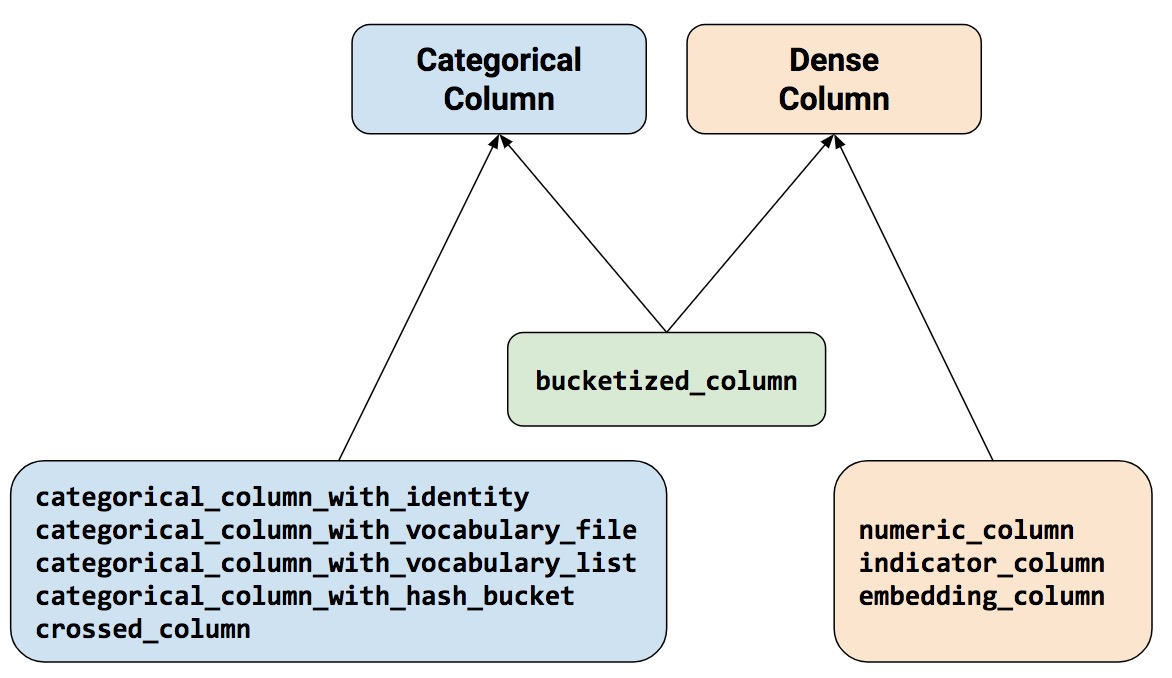

* numeric_column 数值列，最常用。
* bucketized_column 分桶列，由数值列生成，可以由一个数值列出多个特征，one-hot编码。
* categorical_column_with_identity 分类标识列，one-hot编码，相当于分桶列每个桶为1个整数的情况。
* categorical_column_with_vocabulary_list 分类词汇列，one-hot编码，由list指定词典。
* categorical_column_with_vocabulary_file 分类词汇列，由文件file指定词典。
* categorical_column_with_hash_bucket 哈希列，整数或词典较大时采用。
* indicator_column 指标列，由Categorical Column生成，one-hot编码
* embedding_column 嵌入列，由Categorical Column生成，嵌入矢量分布参数需要学习。嵌入矢量维数建议取类别数量的 4 次方根。
* crossed_column 交叉列，可以由除categorical_column_with_hash_bucket的任意分类列构成。

### 二，特征列使用范例

In [2]:
import tensorflow as tf 
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [39]:
# 打印日志
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*6 + "%s"%nowtime)
    print(info + '...\n\n')

In [40]:
#================================================================================
# 一，构建数据管道
#================================================================================
printlog("step1: prepare dataset...")


============================================================2020-04-17 15:27:58
step1: prepare dataset......




In [42]:
# load dataset
dftrain_raw = pd.read_csv('../data/titanic/train.csv')
dftest_raw = pd.read_csv('../data/titanic/test.csv')
dfraw = pd.concat([dftrain_raw, dftest_raw])

In [43]:
# prepare data
def prepare_dfdata(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata = dfdata.rename(columns={'survived':'label'})
    dfdata = dfdata.drop(['passengerid','name'], axis=1)
    for col, dtype in dict(dfdata.dtypes).items():
        # 判断是否包含缺失值
        if dfdata[col].hasnans:
            dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')
        # 填充
            if dtype not in [np.object, np.str, np.unicode]:
                dfdata[col].fillna(dfdata[col].mean(), inplace = True)
            else:
                dfdata[col].fillna('', inplace = True)
    return dfdata

In [44]:
dfdata = prepare_dfdata(dfraw)
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw) :, :]

In [45]:
# 从 dataframe 导入数据 
def df_to_dataset(df, shuffle=True, batch_size=32):
    dfdata = df.copy()
    if 'label' not in dfdata.columns:
        ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient = 'list'))
    else:
        labels = dfdata.pop('label')
        ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient = 'list'), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfdata))
    ds = ds.batch(batch_size)
    return ds

ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)

In [51]:
#================================================================================
# 二，定义特征列
#================================================================================
printlog("step2: make feature columns...")

feature_columns = []

# 数值列
for col in ['age','fare','parch','sibsp'] + [
    c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))

# 分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, 
             boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 类别列
# 注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！！
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='sex',vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='pclass',vocabulary_list=[1,2,3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(
     tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

# 嵌入列
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

# 交叉列
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
          key='pclass',vocabulary_list=[1,2,3])

crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column([age_buckets, pclass_cate],hash_bucket_size=15))

feature_columns.append(crossed_feature)


============================================================2020-04-17 15:29:12
step2: make feature columns......




In [52]:
#================================================================================
# 三，定义模型
#================================================================================
printlog("step3: define model...")

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    layers.DenseFeatures(feature_columns), #将特征列放入到tf.keras.layers.DenseFeatures中!!!
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])



============================================================2020-04-17 15:29:16
step3: define model......




In [54]:
#================================================================================
# 四，训练模型
#================================================================================
printlog("step4: train model...")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_test, epochs=10)


============================================================2020-04-17 15:30:52
step4: train model......


Train for 23 steps, validate for 6 steps
Epoch 1/10
23/23 [==============================] - 3s 128ms/step - loss: 0.6635 - accuracy: 0.6643 - val_loss: 0.5551 - val_accuracy: 0.6872
Epoch 2/10
23/23 [==============================] - 0s 10ms/step - loss: 0.6300 - accuracy: 0.6699 - val_loss: 0.5620 - val_accuracy: 0.6872
Epoch 3/10
23/23 [==============================] - 0s 11ms/step - loss: 0.6046 - accuracy: 0.6966 - val_loss: 0.5768 - val_accuracy: 0.6760
Epoch 4/10
23/23 [==============================] - 0s 9ms/step - loss: 0.5919 - accuracy: 0.7149 - val_loss: 0.5427 - val_accuracy: 0.7318
Epoch 5/10
23/23 [==============================] - 0s 15ms/step - loss: 0.5451 - accuracy: 0.7458 - val_loss: 0.5166 - val_accuracy: 0.7151
Epoch 6/10
23/23 [==============================] - 0s 12ms/step - loss: 0.5342 - accuracy: 0.7528 - val_loss: 0.5032 - val_accuracy: 0.7654
Epoch

In [55]:
#================================================================================
# 五，评估模型
#================================================================================
printlog("step5: eval model...")

model.summary()


============================================================2020-04-17 15:33:09
step5: eval model......


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  3008      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


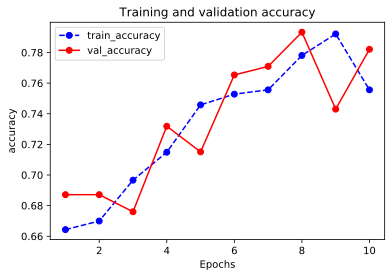

In [58]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    
plot_metric(history, 'accuracy')